[Readn and augment data from TFRecords](#Read-and-augment-data-from-TFRecords)<br>
[Models training using TFRecords data](#Training-using-tfrecords-data)<br>

### Imports 

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
import cv2

import glob
import random

from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# From [TensorFlow guide][1]https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        first_gpu = gpus[0]
        tf.config.experimental.set_virtual_device_configuration(first_gpu,
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=7000)])
    except RuntimeError as e:
        print(e)

ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

In [2]:
first_gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [4]:
tf.__version__

'2.1.0'

In [5]:
!python --version

Python 3.7.9


### Investigating current implementation

In [5]:
import glob
import os
import random

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from tqdm import tqdm

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [6]:
model_filename = 'segm_model_v17_updated_ds.h5'
checkpoint_path = "training_17/weights_updated_ds.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# From [TensorFlow guide][1]https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        first_gpu = gpus[0]
        tf.config.experimental.set_virtual_device_configuration(first_gpu,
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=7000)])
    except RuntimeError as e:
        print(e)

shape = (32, 32)

# model = vanilla_unet(input_shape=(196, 196, 3))

model = custom_unet(
    (32, 32, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model.compile(
    optimizer=Adam(),
    # optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    # loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

model.summary()

Virtual devices cannot be modified after being initialized
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 8)    216         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 8)    32          conv2d_62[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_10 (SpatialDr (None, 32, 32, 8)    0           batch_normalization_36[0][0]     
_________________________________

In [ ]:

if os.path.exists(model_filename):
    print("Loading model from checkpoint {}".format(model_filename))
    model.load_weights(model_filename)


masks = glob.glob(os.path.join("faces", "masks", "*.png"))
orgs = list(map(lambda x: x.replace(".png", ".jpg").replace("masks", "images"), masks))

imgs_list = []
masks_list = []
for image, mask in tqdm(zip(orgs, masks)):
    if os.path.exists(image):
        imgs_list.append(np.array(Image.open(image).resize(shape)))
        masks_list.append(np.array(Image.open(mask).resize(shape))[:, :, -1])

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

# plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)
x = np.asarray(imgs_np, dtype=np.float32) / 255
y = np.asarray(masks_np, dtype=np.float32) / 255
print(x.max(), y.max())
del imgs_np
del masks_np

y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
print(x.shape, y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.30, random_state=0)

del x
del y

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

train_gen = get_augmented(
    x_train, y_train, batch_size=1024,
    data_gen_args=dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

history = model.fit(
    train_gen,
    steps_per_epoch=35,
    epochs=15150,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

# plot_segm_history(history)
#
# model.load_weights(model_filename)
# y_pred = model.predict(x_val)
#
# plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)


### Investigating used dataset

In [3]:
os.listdir('/home/aholdobin/faces')

['masks', 'images']

In [4]:
path_to_dataset = '/home/aholdobin/faces'

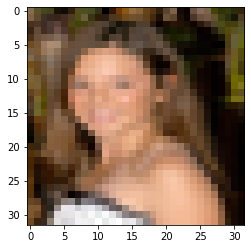

In [106]:
plt.imshow(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg').resize(shape))
plt.show()

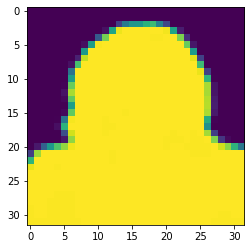

In [107]:
plt.imshow(np.array(Image.open('/home/aholdobin/faces/masks/1803151818-00000118.png').resize(shape))[:,:,-1])
plt.show()

In [82]:
img_1= np.array(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg'))

img_1.shape

(800, 600, 3)

In [76]:
msk_2 = np.array(Image.open('/home/aholdobin/faces/masks/1803151818-00000118.png'))

msk_2.shape

(800, 600, 4)

In [25]:
os.path.sep

'/'

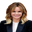

In [108]:
img = Image.open('/home/aholdobin/faces/masks/1803151818-00000118.png'); img.resize(shape)

In [31]:
type([1, 4]) is list

True

In [36]:
plt.figure(figsize=(3,3))
plt.show()

<Figure size 216x216 with 0 Axes>

In [69]:
def show_images_grid(size, path):
    """Plots images in the grid (size * 2 by size), from files in the *path*/images and *path*/masks"""
    masks_path = path + "/masks/"
    images_path = path + "/images/"
    files = os.listdir(images_path)
    chosen = np.random.choice(files, size * size, replace=False)
    chosen_masks = list(map(lambda x: x[:-3]+'png', chosen))
    plt.figure(figsize=(5,15))#(figsize=(size*3*2, size*3))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0.025, hspace=0.05) 
    for i in range(size):
        for j in range(size):
            plt.subplot(size*2, size, size*i*2 + j + 1)
            plt.imshow(Image.open(images_path+chosen[i*size+j])); 
            plt.axis('off')
            plt.subplot(size*2, size, size*(i*2 + 1) + j + 1)
            plt.imshow(Image.open(masks_path+chosen_masks[i*size+j]))
            plt.axis('off')


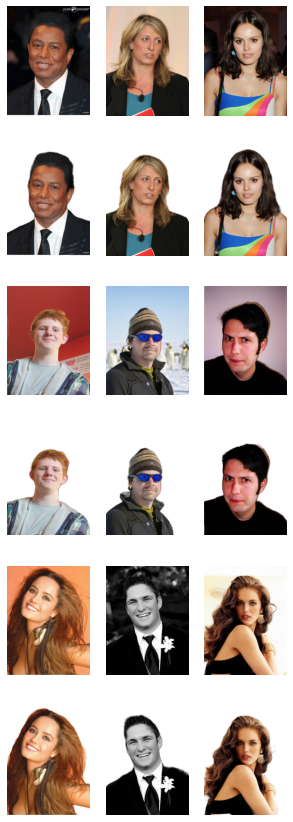

In [70]:
show_images_grid(3, '/home/aholdobin/faces/')

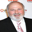

In [109]:
Image.open('/home/aholdobin/faces/images/1803151818-00000048.jpg').resize(shape)

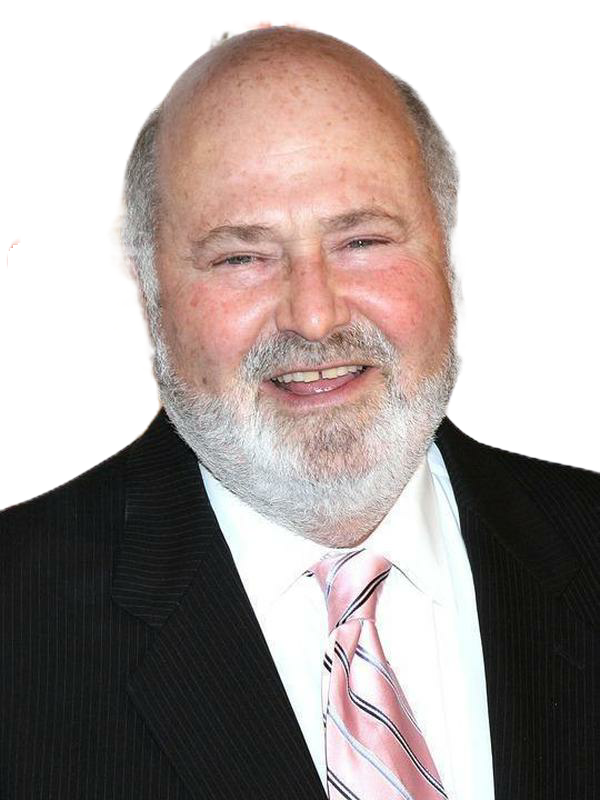

In [85]:
Image.open('/home/aholdobin/faces/masks/1803151818-00000048.png')

### Exploring data in the PASCAL VOC dataset

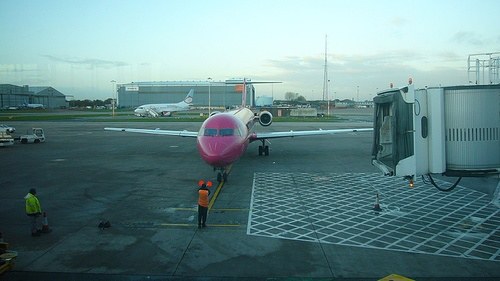

In [89]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg')

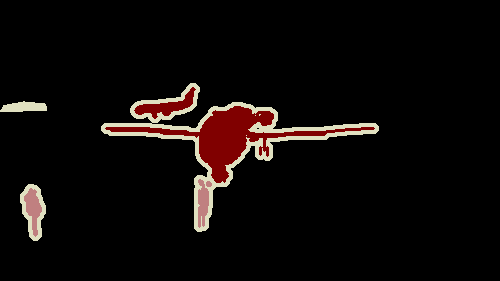

In [88]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')

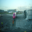

In [111]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg').resize(shape)

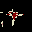

In [110]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png').resize(shape)

In [91]:
mask_200732 = Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')

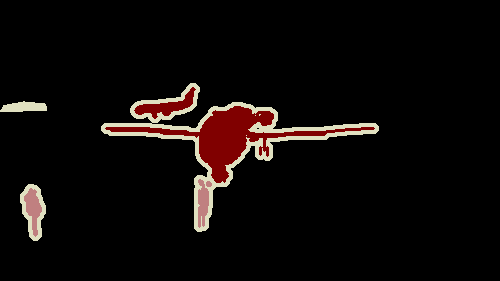

In [92]:
mask_200732

In [93]:
type(mask_200732)

PIL.PngImagePlugin.PngImageFile

In [90]:
msk_2 = np.array(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'))

msk_2.shape

(281, 500)

In [96]:
msk_2[140:200,230:280]

array([[  1,   1,   1, ..., 255, 255, 255],
       [  1,   1,   1, ..., 255, 255, 255],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

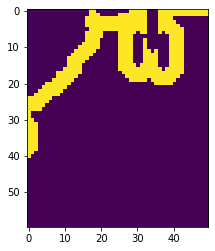

In [112]:
plt.imshow(msk_2[140:200, 230:280])

In [103]:
pascal_voc_home = '/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/' 
segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
with open(segmentation_meta_path) as f:
    segmentation_files = f.read().split('\n')

In [115]:
msk_2[160:240,180:240]

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

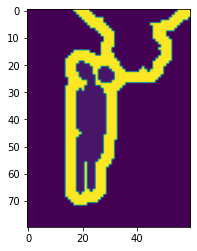

In [114]:
plt.imshow(msk_2[160:240, 180:240])

#### Checking different image sizes 

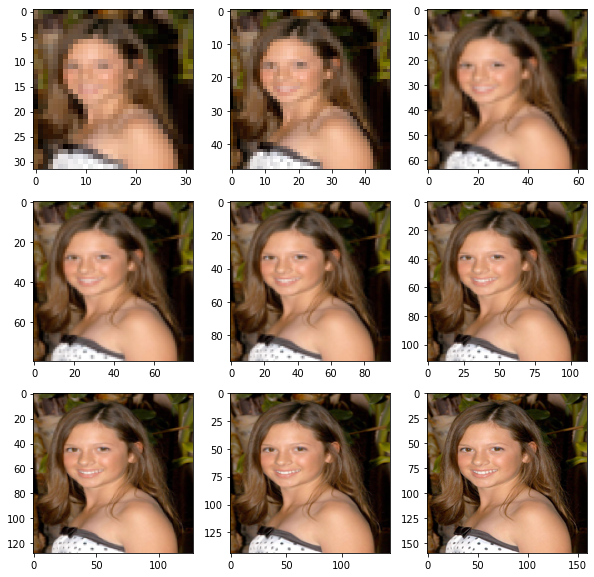

In [129]:
img_shapes = Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg')
plt.figure(figsize=(10,10))
i = 0
for size in range(32,161,16):
    plt.subplot(3, 3, i+1)
    plt.imshow(img_shapes.resize((size, size)))
    i+=1
plt.show()

In [3]:
model_tmp = custom_unet(
    (1024, 1024, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model_tmp.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)
#print('#'*100+f"\nParameters in model (shape: {shp} x {shp} x 3)")
model_tmp.summary()
del model_tmp

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 1024, 1024, 8 216         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 1024, 1024, 8 32          conv2d_31[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_5 (SpatialDro (None, 1024, 1024, 8 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

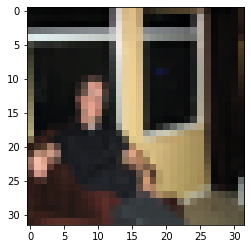

In [8]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_003530.jpg').resize(shape))

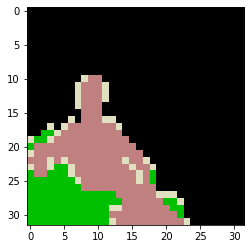

In [10]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize(shape))

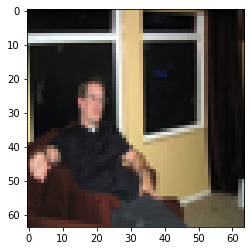

In [12]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_003530.jpg').resize((64, 64)))

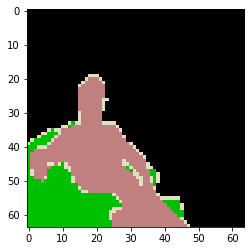

In [11]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize((64,64)))

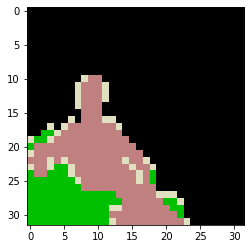

In [10]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize(shape))

In [14]:
mask_tmp = np.array(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize(shape))

In [15]:
mask_tmp[10, 10]

15

In [16]:
PASCAL_VOC_PERSON_CLASS_ID = 15

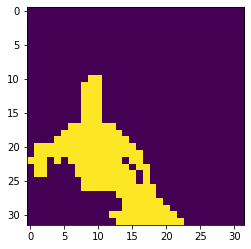

In [17]:
plt.imshow(mask_tmp == 15)

### Implementation of PASCAL VOC 2012 Segmentation data preprocessing

In [24]:
%time
(mask_tmp == PASCAL_VOC_PERSON_CLASS_ID).astype('uint8')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [26]:
(mask_tmp == PASCAL_VOC_PERSON_CLASS_ID).mean()

0.1708984375

In [28]:
(np.array(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_005988.png').resize(shape)) == PASCAL_VOC_PERSON_CLASS_ID).mean()

0.07421875

In [48]:
tmp = np.random.randint(2, size=[10000,32,32])

In [49]:
len(tmp)

10000

In [50]:
%time
tmp2 = (tmp == 1).astype('uint8')
right = []
for i in range(len(tmp)):
    right.append(tmp2[i].mean() > 0.15)
tmp2 = tmp2[np.array(right, dtype=bool)]
    

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


In [ ]:
size(right

In [47]:
all(right)

True

In [39]:
tmp[0]

array([[0, 1, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 0, 1]])

In [ ]:
img1 = Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/')

In [125]:
y_train.max()

1.0

In [62]:
pascal_voc_home = '/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/' 
segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
main_meta_path =  pascal_voc_home + 'ImageSets/Main/person_trainval.txt'
segmentation_folder = pascal_voc_home + 'SegmentationClass/'
images_folder = pascal_voc_home + 'JPEGImages/'

In [67]:
with open(segmentation_meta_path) as f:
    segmentation_files = f.read().split('\n')[:-1]
with open(main_meta_path) as f:
    person_files = f.read().split('\n')

In [60]:
len(segmentation_files), len(person_files), len(set(person_files)-set(segmentation_files))

(2914, 11541, 11540)

In [ ]:
shape = (32, 32)
images = []
masks = []
for file in segmentation_files:
    images.append(np.array(Image.open(images_folder + file + '.jpg').resize(shape)))
    masks.append(np.array(Image.open(segmentation_folder + file + '.png').resize(shape)) 
                 == PASCAL_VOC_PERSON_CLASS_ID)
# !!! ^^^ wrong: firtsly we need to get 0-1 for background/human secondly we need to resize !!!
X = np.array(images)/255.
y = np.array(masks, dtype='float16')

right = np.reshape(y, [y.shape[0], shape[0]*shape[1]]).mean(axis=1)
right = (right >.15) | (right == .0)
print(sum(right))

X = X[right]
y = y[right]

y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

# del X
# del y

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

In [92]:
# y = np.concatenate([y_train, y_val])
# X = np.concatenate([x_train, x_val])

1680

In [97]:
ls = os.listdir('/home/aholdobin/faces/images/')

In [101]:
all(list(map(lambda x: x.endswith('jpg'), ls)))

False

In [6]:
import gc
gc.collect()

3875

In [7]:
PASCAL_VOC_PERSON_CLASS_ID = 15

### Combining data from two datasets into one

In [10]:
def prepare_pascal_voc_dataset(pascal_voc_home='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/',
                               coco_home='/home/aholdobin/faces/',
                               shape=(32, 32),
                               verbose=False):
    gc.collect()
    # LOADING PASCAL_VOC DATA IF PROVIDED
    
    images = []
    masks = []
    
    if pascal_voc_home and os.path.exists(pascal_voc_home):
        segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
        segmentation_folder = pascal_voc_home + 'SegmentationClass/'
        images_folder = pascal_voc_home + 'JPEGImages/'

        with open(segmentation_meta_path) as f:
            segmentation_files = f.read().split('\n')[:-1]

        for file in tqdm(segmentation_files):
            if os.path.exists(images_folder + file + '.jpg'):
                images.append(np.array(Image.open(images_folder + file + '.jpg').resize(shape)))
                masks.append(np.array(Image.open(segmentation_folder + file + '.png').resize(shape)) 
                             == PASCAL_VOC_PERSON_CLASS_ID)

        X_pv = np.array(images)/255.
        y_pv = np.array(masks, dtype='float16')

        right = np.reshape(y_pv, [y_pv.shape[0], shape[0]*shape[1]]).mean(axis=1)
        right = (right >.15) | (right == .0)
        if verbose:
            print(sum(right))
        X_pv = X_pv[right]
        y_pv = y_pv[right]
        
        if verbose:
            print("x_pv: ", X_pv.shape)
            print("y_pv: ", y_pv.shape)
        
    del images
    del masks
    gc.collect()
    # LOADING COCO DATA IF PROVIDED
    images = []
    masks = []
    if coco_home and os.path.exists(coco_home):
        files = os.listdir(coco_home+'images/')
        if verbose: print('files len', len(files))
        files = list(map(lambda x: x[:-4] if x.endswith('jpg') else None, files))
        i=0
        for file in tqdm(files):
            i+=1
            if i<30: print(os.path.exists(coco_home + f'images/{file}.jpg'))
            if file and os.path.exists(coco_home + f'images/{file}.jpg'):
                
                images.append(np.array(Image.open(coco_home + f'images/{file}.jpg').resize(shape)))
                masks.append(np.array(Image.open(coco_home + f'masks/{file}.png').resize(shape))[:, :, -1])
        
        X_c = np.asarray(images, dtype=np.float32) / 255
        y_c = np.asarray(masks, dtype='float16') / 255
        
    X = np.concatenate([X_pv, X_c])
    y = np.concatenate([y_pv, y_c])
    y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
    
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

    # del X
    # del y
    if verbose:
        print("x_train: ", x_train.shape)
        print("y_train: ", y_train.shape)
        print("x_val: ", x_val.shape)
        print("y_val: ", y_val.shape)
        
    return x_train, y_train, x_val, y_val
    

In [ ]:
x_train, y_train, x_val, y_val = prepare_pascal_voc_dataset(verbose=True)

In [12]:
gc.collect()

20

### Training the model on the created dataset

In [13]:
model_filename = 'segm_model_v17_updated_ds.h5'
checkpoint_path = "training_17/weights_updated_ds.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# From [TensorFlow guide][1]https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        first_gpu = gpus[0]
        tf.config.experimental.set_virtual_device_configuration(first_gpu,
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=7000)])
    except RuntimeError as e:
        print(e)

shape = (32, 32)

# model = vanilla_unet(input_shape=(196, 196, 3))

model = custom_unet(
    (32, 32, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model.compile(
    optimizer=Adam(),
    # optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    # loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 32, 32, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
gc.collect()
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           )

train_gen = get_augmented(
    x_train, y_train, batch_size=1024,
    data_gen_args=dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

history = model.fit(
    train_gen,
    steps_per_epoch=25,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint
              # , es_callback
              ]
)

In [15]:
import pickle
with open('data_dict.p','wb') as f:
    pickle.dump({'x_train':x_train, "y_train":y_train,'x_val':x_val, "y_val":y_val,}, f)

In [16]:
gc.collect()

524

In [ ]:
history2 = model.fit(
    train_gen,
    steps_per_epoch=25,
    epochs=8000,
    initial_epoch=1000,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint
              # , es_callback
              ]
)

In [19]:
x_train.shape, len(x_train)

((25774, 32, 32, 3), 25774)

In [28]:
type(x_train[1])

numpy.ndarray

### Investigating results 

In [103]:
def show_val_samples(data, size=[2,4], check_all=False):
    if check_all:
        idx = np.arange(len(data[0]))[:size[0]*size[1]]
        print(idx)
    else:
        idx = np.random.randint(len(data[0]),size=[size[0]*size[1]])
#     print(idx)
    plt.figure(figsize=(size[0]*8, size[1]*4))
    for i in range(size[0]):
        for j in range(size[1]):
            plt.subplot(size[0]*2, size[1], size[1]*i*2 + j + 1)
            print(size[1]*i*2 + j + 1)
            plt.imshow(data[0][idx[i*size[1]+j]].astype(float)); 
            plt.axis('off')
            plt.subplot(size[0]*2, size[1], size[1]*(i*2 + 1) + j + 1)
            print(size[1]*(i*2 + 1) + j + 1)
            plt.imshow(data[1][idx[i*size[1]+j]].astype(float))
            plt.axis('off')
    plt.show()
    return (data[0][idx], data[1][idx])

1
5
2
6
3
7
4
8
9
13
10
14
11
15
12
16


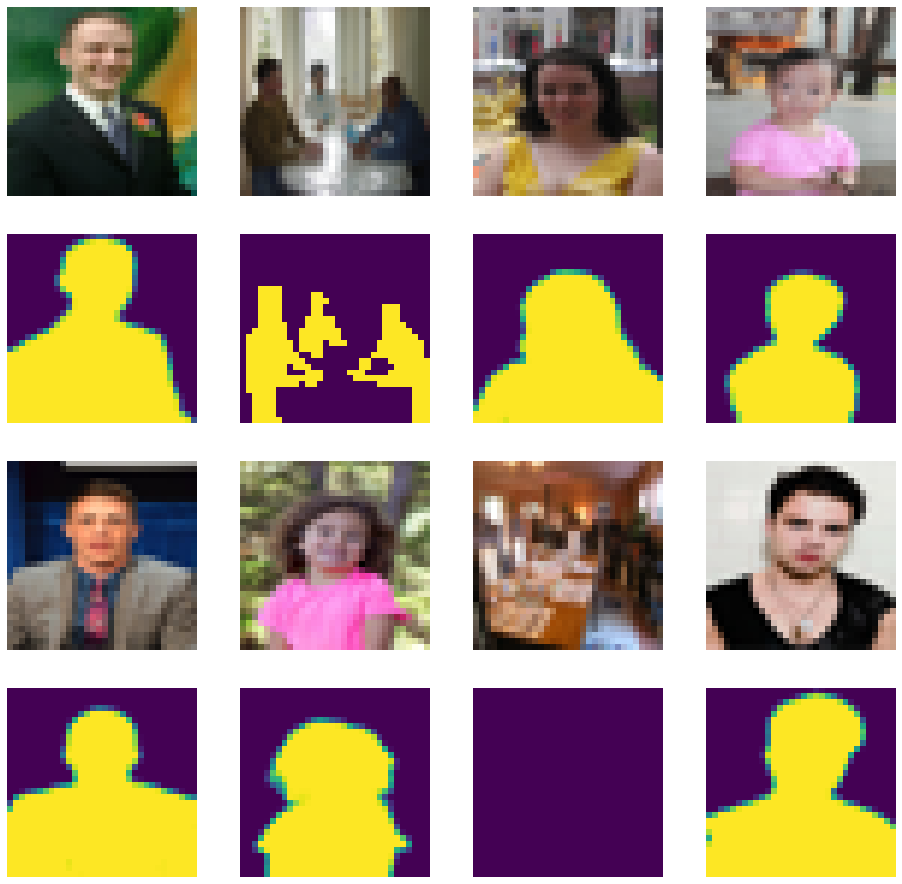

In [95]:
xsamples, ysamples = show_val_samples((x_val, y_val))

In [74]:
ysamples[0].mean()

0.493

In [75]:
ysamples.mean()

0.526

In [76]:
ysamples.reshape(len(ysamples),-1).mean(axis=1)

array([0.493 , 0.4636, 0.3796, 0.588 , 0.526 , 0.692 , 0.5044, 0.5615],
      dtype=float16)

In [96]:
yhatsamples = model.predict(xsamples)

[0 1 2 3 4 5 6 7]
1
5
2
6
3
7
4
8
9
13
10
14
11
15
12
16


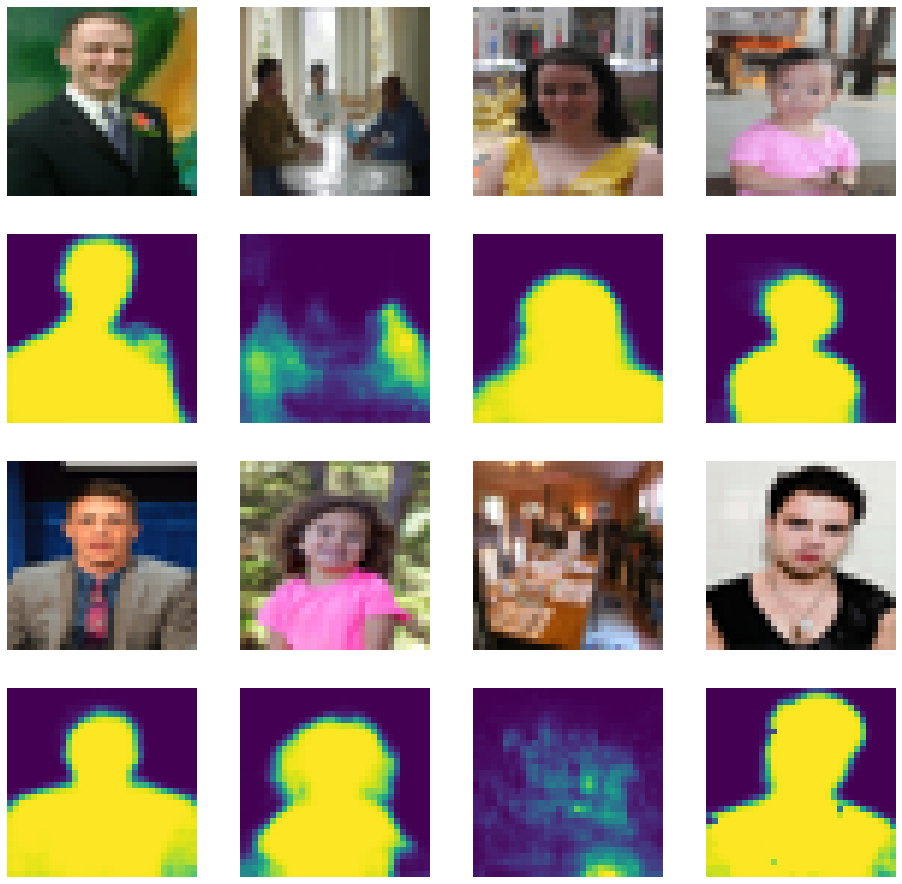

In [104]:
_ = show_val_samples((xsamples, yhatsamples), check_all=True)

In [100]:
np.arange(5)[3]

3

In [85]:
meanvalues = y_val.reshape(len(y_val),-1).mean(axis=1)

In [84]:
y_val.mean()

0.508

(array([ 603.,    0.,    0.,   25.,   22.,   17.,  154.,  562., 1157.,
        1661., 1552., 1490., 1381., 1065.,  739.,  379.,  151.,   63.,
          21.,    5.]),
 array([0.     , 0.04803, 0.09607, 0.144  , 0.1921 , 0.2401 , 0.288  ,
        0.3362 , 0.3843 , 0.4321 , 0.4802 , 0.5283 , 0.576  , 0.6245 ,
        0.6724 , 0.72   , 0.7686 , 0.8164 , 0.8643 , 0.9126 , 0.9604 ],
       dtype=float16),
 <BarContainer object of 20 artists>)

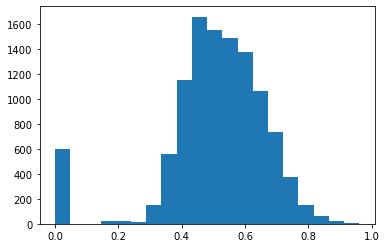

In [105]:
plt.hist(meanvalues, bins=20)

In [ ]:
old_model

In [107]:
2

2

In [111]:
meanpixels = y_val.reshape((len(y_val), -1)).mean(axis=0).reshape((32, 32))

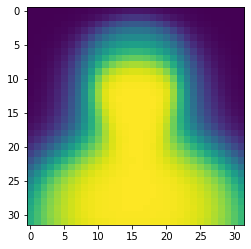

In [115]:
ax = plt.imshow(meanpixels.astype(float))

In [119]:
model

###  Converting models into TFLite format

In [120]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_of8000 = converter.convert()
with open('semsegm_of8000.tflite', 'wb') as f:
    f.write(tflite_model_of8000)

In [122]:
def save_bunch_of_models(model, unique_name):
    optimizations = [
        (tf.lite.Optimize.DEFAULT, tf.float32, "default_32fp"),
        (tf.lite.Optimize.DEFAULT, tf.float16, "default_16fp"),
        (tf.lite.Optimize.OPTIMIZE_FOR_LATENCY, tf.float32, "latency_32fp"),
        (tf.lite.Optimize.OPTIMIZE_FOR_LATENCY, tf.float16, "latency_16fp")
    ]

    for optimization, tensor_type, name in optimizations:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.post_training_quantize = True
        converter.optimizations = [optimization]
        converter.target_spec.supported_types = [tensor_type]
        tflite_model = converter.convert()
        open(os.path.join("tflite", "{}_{}.tflite".format(unique_name, name)), "wb").write(tflite_model)

In [124]:
save_bunch_of_models(model=model, unique_name='semsegm_of8000')

In [125]:
!ls tflite

segm_model_v5_0065_default_16fp.tflite	segm_model_v9_latency_16fp.tflite
segm_model_v5_0065_default_32fp.tflite	segm_model_v9_latency_32fp.tflite
segm_model_v5_0065_latency_16fp.tflite	semsegm_of8000_default_16fp.tflite
segm_model_v5_0065_latency_32fp.tflite	semsegm_of8000_default_32fp.tflite
segm_model_v9_default_16fp.tflite	semsegm_of8000_latency_16fp.tflite
segm_model_v9_default_32fp.tflite	semsegm_of8000_latency_32fp.tflite


### Implementing module for training with different parameters
(Complete results are in the AUnetBackgroundRemover.py)

In [135]:
def prepare_pascal_voc_dataset(pascal_voc_home='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/',
                               coco_home='/home/aholdobin/faces/',
                               shape=(32, 32),
                               verbose=False):
    gc.collect()
    # LOADING PASCAL_VOC DATA IF PROVIDED
    
    images = []
    masks = []
    
    if pascal_voc_home and os.path.exists(pascal_voc_home):
        segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
        segmentation_folder = pascal_voc_home + 'SegmentationClass/'
        images_folder = pascal_voc_home + 'JPEGImages/'

        with open(segmentation_meta_path) as f:
            segmentation_files = f.read().split('\n')[:-1]

        for file in tqdm(segmentation_files):
            if os.path.exists(images_folder + file + '.jpg'):
                images.append(np.array(Image.open(images_folder + file + '.jpg').resize(shape)))
                masks.append(cv2.resize(np.array(Image.open(segmentation_folder + file + '.png')) == PASCAL_VOC_PERSON_CLASS_ID,dsize=shape)) 
                            

        X_pv = np.array(images)/255.
        y_pv = np.array(masks, dtype='float16')

        right = np.reshape(y_pv, [y_pv.shape[0], shape[0]*shape[1]]).mean(axis=1)
        right = (right >.15) | (right == .0)
        if verbose:
            print(sum(right))
        X_pv = X_pv[right]
        y_pv = y_pv[right]
        
        if verbose:
            print("x_pv: ", X_pv.shape)
            print("y_pv: ", y_pv.shape)
        
    del images
    del masks
    gc.collect()
    # LOADING COCO DATA IF PROVIDED
    images = []
    masks = []
    if coco_home and os.path.exists(coco_home):
        files = os.listdir(coco_home+'images/')
        if verbose: print('files len', len(files))
        files = list(map(lambda x: x[:-4] if x.endswith('jpg') else None, files))
        i=0
        for file in tqdm(files):
            i+=1
            if i<30: print(os.path.exists(coco_home + f'images/{file}.jpg'))
            if file and os.path.exists(coco_home + f'images/{file}.jpg'):
                
                images.append(np.array(Image.open(coco_home + f'images/{file}.jpg').resize(shape)))
                masks.append(np.array(Image.open(coco_home + f'masks/{file}.png').resize(shape))[:, :, -1])
        
        X_c = np.asarray(images, dtype=np.float32) / 255
        y_c = np.asarray(masks, dtype='float16') / 255
        
    X = np.concatenate([X_pv, X_c])
    y = np.concatenate([y_pv, y_c])
    y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
    
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

    # del X
    # del y
    if verbose:
        print("x_train: ", x_train.shape)
        print("y_train: ", y_train.shape)
        print("x_val: ", x_val.shape)
        print("y_val: ", y_val.shape)
        
    return x_train, y_train, x_val, y_val
    
class AUnetBackgroundRemoval:
    
    def __init__(self, input_shape=(32, 32), filters=8, verbose=0, use_attention=True,
                checkpoint_folder='training_grid/'):
        self.__verbose = verbose
        self.__input_shape = (input_shape[0], input_shape[1], 3)
        self.__filters = filters
        self.__model = custom_unet(
            self.__input_shape,
            use_batch_norm=True,
            num_classes=1,
            filters=self.__filters,
            use_attention=use_attention,
            dropout=0.2,
            output_activation='sigmoid'
        )

        model.compile(
            optimizer=Adam(),
            loss='binary_crossentropy',
            metrics=[iou, iou_thresholded]
        )
        if verbose:
            model.summary()
            
    def train(self, x_train, y_train, x_val, y_val, epochs=1000, batch_size=1024, augm_args=dict(
                rotation_range=15.,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=50,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=False,
                fill_mode='constant'
            )):
        
        train_gen = get_augmented(
            x_train, y_train, batch_size=batch_size,
            data_gen_args=augm_args)

        callback_checkpoint = ModelCheckpoint(
            filepath=self.__checkpoint_path,
            verbose=self.__verbose,
            monitor='val_loss',
            save_best_only=True,
        )

        self.__history = self.__model.fit(
            train_gen,
            steps_per_epoch=(len(X_train)+batch_size-1)//batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[callback_checkpoint]
        )
    
    def predict(self, x):
        if len(x.shape == 3):
            return self.__model.predict(x.reshape((1, * x.shape)))
    
    

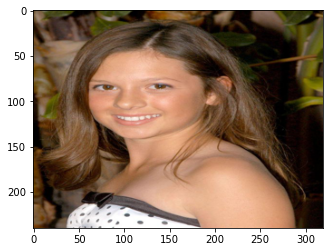

In [6]:
%matplotlib inline
plt.imshow(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg').resize((320,240)))
plt.show()

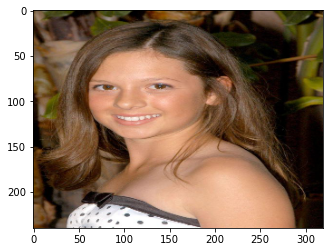

In [9]:
%matplotlib inline
plt.imshow(cv2.resize(np.array(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg')), dsize=(320, 240)))
plt.show()

In [12]:
9

9

In [14]:
import argparse
parser = argparse.ArgumentParser(prog='AUnetBackgroundRemoval', description='Attention UNet parametrizable model trainer for background removal')
parser.add_argument('-p', '--pascal-voc-path', required=False, dest='pascal_voc_path')
parser.add_argument('-c', '--coco-portraints-path', required=False, dest='coco_portraits_path')
parser.add_argument('-s', '--supervisely-person-path', required=False, dest='supervisely_person_path')
parser.add_argument('-up', '--use_pascal-voc-path', action='store_true', required=False, dest='use_pascal_voc')
parser.add_argument('-uc', '--use-coco-portraints-path', action='store_true', required=False, dest='use_coco_portraits_voc')
parser.add_argument('-us', '--use-supervisely-person-path', action='store_true', required=False, dest='use_supervisely_person_voc')
parser.add_argument('-e', '--epochs', type=int, required=False, dest='epochs', default=1000)
parser.add_argument('-b', '--batch-size', type=int, required=False, dest='batch_size', default=8)
parser.add_argument('-v', '--verbose', type=int, required=False, dest='verbose', default=0)

_StoreAction(option_strings=['-v', '--verbose'], dest='verbose', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [16]:
args = parser.parse_args([])

In [17]:
if None and True:
    print('')

In [18]:
!python --version

Python 3.7.9


In [90]:
!python AUnetBackgroundRemoval.py -up -b 256 -e 5 -sd 128 -f 16 -v 1 --remove-previous-results

2020-09-15 18:31:55.287017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-09-15 18:31:55.288074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
2020-09-15 18:31:56.129873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-15 18:31:56.148419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:31:56.148817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability:

  ...
    to  
  ['...']
Train for 7 steps, validate on 713 samples
Epoch 1/5
2020-09-15 18:32:18.994472: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-09-15 18:32:19.950492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-15 18:32:21.769838: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-09-15 18:32:21.769864: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-09-15 18:32:21.810756: 

2020-09-15 18:32:47.851930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:47.852193: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2020-09-15 18:32:47.852254: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-09-15 18:32:47.852888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:47.853090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2020-09-15 18:32:47.853123: 

2020-09-15 18:32:51.150683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:51.150938: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2020-09-15 18:32:51.151042: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-09-15 18:32:51.151612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:51.151821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2020-09-15 18:32:51.151857: 

2020-09-15 18:32:53.286688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:53.286961: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2020-09-15 18:32:53.287035: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-09-15 18:32:53.287397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:53.287604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2020-09-15 18:32:53.287642: 

In [80]:
os.listdir('training_grid/fil_8_shape_32x32/')

['history_fil_8_shape_32x32.json',
 'weights.0001-0.63.hdf5',
 'weights.0002-0.63.hdf5',
 'weights.0004-0.62.hdf5',
 'weights.0003-0.63.hdf5',
 'tflite']

In [81]:
!cat training_grid/fil_8_shape_32x32/history_fil_8_shape_32x32.json

{"loss": [0.8595703652030543, 0.8212387330794448, 0.795344514424721, 0.774553344010166, 0.7571181452445437], "iou": [0.045431021600961685, 0.04815731942653656, 0.04897861182689667, 0.04706428200006485, 0.04706677049398422], "iou_thresholded": [0.04534188657999039, 0.04898189753293991, 0.050028130412101746, 0.048407573252916336, 0.049409106373786926], "val_loss": [0.6338825225830078, 0.6301223039627075, 0.6252729892730713, 0.624085545539856, 0.625603973865509], "val_iou": [0.04222794622182846, 0.042097318917512894, 0.0419737882912159, 0.04195978865027428, 0.04205095022916794], "val_iou_thresholded": [0.03083406575024128, 0.030587557703256607, 0.031410373747348785, 0.0324016809463501, 0.030612992122769356]}

In [54]:
os.listdir('training_grid/fil_8_shape_32x32/tflite/')

['fil_8_shape_32x32_default_32fp.tflite',
 'fil_8_shape_32x32_default_16fp.tflite',
 'fil_8_shape_32x32_latency_16fp.tflite',
 'fil_8_shape_32x32_latency_32fp.tflite']

In [43]:
os.listdir('training_grid/fil_8_shape_32x32')[0][8:].split('-')[0]

'.03'

In [44]:
lambda x: x[8:].split('-')[0]

<function __main__.<lambda>(x)>

In [47]:
checkpoints = os.listdir('/home/aholdobin/ar-video-conf-mobile-demo/python/training_grid/fil_8_shape_32x32/')
checkpoints = list(map(lambda x: (x, int(x[8:].split('-')[0])), checkpoints))
checkpoints = sorted(checkpoints, key=lambda x:x[1])

In [48]:
checkpoints

[('weights.01-0.69.hdf5', 1),
 ('weights.02-0.69.hdf5', 2),
 ('weights.03-0.69.hdf5', 3),
 ('weights.04-0.68.hdf5', 4),
 ('weights.05-0.68.hdf5', 5),
 ('weights.06-0.67.hdf5', 6),
 ('weights.07-0.67.hdf5', 7),
 ('weights.08-0.67.hdf5', 8),
 ('weights.09-0.66.hdf5', 9),
 ('weights.10-0.65.hdf5', 10)]

In [49]:
checkpoints = os.listdir('/home/aholdobin/ar-video-conf-mobile-demo/python/training_grid/fil_8_shape_32x32/')
checkpoints = sorted(checkpoints)

In [50]:
checkpoints

['weights.01-0.69.hdf5',
 'weights.02-0.69.hdf5',
 'weights.03-0.69.hdf5',
 'weights.04-0.68.hdf5',
 'weights.05-0.68.hdf5',
 'weights.06-0.67.hdf5',
 'weights.07-0.67.hdf5',
 'weights.08-0.67.hdf5',
 'weights.09-0.66.hdf5',
 'weights.10-0.65.hdf5']

In [58]:
import json

with open('w.json', 'w') as f:
    json.dump({1:'22'}, f)

In [82]:
import json

with open('w.json', 'w') as f:
    json.dump({1:list(map(lambda x: float(x), [data,data,data,data]))}, f)

In [73]:
!cat w.json
!rm w.json

{"1": [0.0, 0.0, 0.0, 0.0]}

In [84]:
import json

with open('w.json') as f:
    print(json.load(f))

{'1': [0.0, 0.0, 0.0, 0.0]}


In [70]:
data = np.zeros([1])

In [92]:
import subprocess

In [94]:
'{r}, {d}'.format(r=2,d=3,c=4)

KeyError: 'add'

### Training models with different input size and number of features

In [113]:
cmd = 'python AUnetBackgroundRemoval.py -uc -up -sd {side} -b {batch_size} -e {epochs} -f {filters}' # ' > {name}.log'
cmd_tst = 'python AUnetBackgroundRemoval.py -up -sd {side} -b {batch_size} -e 1 -f {filters}'



models_parameters = [
        {'name': 'side32_filters8',
        'side': 32,
        'batch_size': 1024,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side64_filters8',
        'side': 64,
        'batch_size': 512,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side128_filters8',
        'side': 128,
        'batch_size': 256,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side32_filters16',
        'side': 32,
        'batch_size': 1024,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side64_filters16',
        'side': 64,
        'batch_size': 512,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side128_filters16',
        'side': 128,
        'batch_size': 256,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side32_filters12',
        'side': 32,
        'batch_size': 1024,
        'filters': 12,
        'epochs': 500
    },
        {'name': 'side64_filters12' ,
        'side': 64,
        'batch_size': 512,
        'filters': 12,
        'epochs': 500
    },
        {'name': 'side128_filters12' ,
        'side': 128,
        'batch_size': 256,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
]

In [110]:
for value in models_parameters:
    #print(cmd.format(**value))
    #proc = subprocess.call(cmd.format(**value), stderr=subprocess.STDOUT, stdout='/dev/null')
    
    proc = subprocess.call(cmd_tst.format(**value).split(), stderr=subprocess.STDOUT)
    print(proc)

0
0
0
0
0
0
0
0
0


In [ ]:
for value in models_parameters:
    with open(value['name'] + '.log', 'w') as f:
        proc = subprocess.call(cmd.format(**value).split(), stdout=f, stderr=subprocess.STDOUT)
    print(proc)

0
0
1
0


In [117]:
cmd_tflite = 'python AUnetBackgroundRemoval.py -sd {side} -f {filters} -l'


models_parameters = [
        {'name': 'side32_filters8',
        'side': 32,
        'batch_size': 1024,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side64_filters8',
        'side': 64,
        'batch_size': 512,
        'filters': 8,
        'epochs': 500
    },
#         {'name': 'side128_filters8',
#         'side': 128,
#         'batch_size': 256,
#         'filters': 8,
#         'epochs': 500
#     },
        {'name': 'side32_filters16',
        'side': 32,
        'batch_size': 1024,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side64_filters16',
        'side': 64,
        'batch_size': 512,
        'filters': 16,
        'epochs': 500
    },
#         {'name': 'side128_filters16',
#         'side': 128,
#         'batch_size': 256,
#         'filters': 16,
#         'epochs': 500
#     },
        {'name': 'side32_filters12',
        'side': 32,
        'batch_size': 1024,
        'filters': 12,
        'epochs': 500
    },
        {'name': 'side64_filters12' ,
        'side': 64,
        'batch_size': 512,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side128_filters12' ,
#         'side': 128,
#         'batch_size': 256,
#         'filters': 12,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
]

for value in models_parameters:
    proc = subprocess.call(cmd_tflite.format(**value).split())
    print(value['name'], proc)

side32_filters8 0
side64_filters8 0
side32_filters16 0
side64_filters16 0
side32_filters12 0
side64_filters12 0


In [120]:
cmd = 'python AUnetBackgroundRemoval.py -l -uc -up -sd {side} -b {batch_size} -e {epochs} -f {filters}' # ' > {name}.log'
cmd_tst = 'python AUnetBackgroundRemoval.py -up -sd {side} -b {batch_size} -e 1 -f {filters}'

models_parameters128 = [
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side64_filters8',
#         'side': 64,
#         'batch_size': 512,
#         'filters': 8,
#         'epochs': 500
#     },
        {'name': 'side128_filters8',
        'side': 128,
        'batch_size': 256,
        'filters': 8,
        'epochs': 500
    },
#         {'name': 'side32_filters16',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 16,
#         'epochs': 500
#     },
#         {'name': 'side64_filters16',
#         'side': 64,
#         'batch_size': 512,
#         'filters': 16,
#         'epochs': 500
#     },
        {'name': 'side128_filters16',
        'side': 128,
        'batch_size': 256,
        'filters': 16,
        'epochs': 500
    },
#         {'name': 'side32_filters12',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 12,
#         'epochs': 500
#     },
#         {'name': 'side64_filters12' ,
#         'side': 64,
#         'batch_size': 512,
#         'filters': 12,
#         'epochs': 500
#     },
        {'name': 'side128_filters12' ,
        'side': 128,
        'batch_size': 256,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,htop
#         'epochs': 500
#     },
]

for value in models_parameters128:
    with open(value['name'] + '.log2', 'w') as f:
        proc = subprocess.call(cmd.format(**value).split(), stdout=f, stderr=subprocess.STDOUT)
    print(proc)

1
1
1


## Implementation based on TFRecordDataset
As problem with memory management occured with input size 128 by 128, new approach was implemented

In [140]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def prepare_and_store_dataset(pascal_voc_home='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/',
                              coco_home='/home/aholdobin/faces/',
                              tfrecords_dest='/home/aholdobin/tfrecords/',
                              shape=(32, 32),
                              verbose=False):

    if not os.path.exists(tfrecords_dest):
        os.mkdir(tfrecords_dest)
        
    NUMBER_OF_EXAMPLES_IN_FILE = 200 * 10**6 // shape[0] // shape[1] // 3 // 4
    filenames = []
    # CREATING PASCAL_VOC DATA IF PROVIDED
    if pascal_voc_home and os.path.exists(pascal_voc_home):
        
        segmentation_meta_path = pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
        segmentation_folder = pascal_voc_home + 'SegmentationClass/'
        images_folder = pascal_voc_home + 'JPEGImages/'

        with open(segmentation_meta_path) as f:
            segmentation_files = f.read().split('\n')

        i = 0
        FILE_NUM = 0
        # NUMBER_OF_TFRECORDS = (len(segmentation_files) + NUMBER_OF_EXAMPLES_IN_FILE-1)//NUMBER_OF_EXAMPLES_IN_FILE
        filename_pattern = "pascalvoc_{}x{}_{}.tfrecord"
        filename = filename_pattern.format(shape[0], shape[1], FILE_NUM)
        writer = tf.io.TFRecordWriter(os.path.join(tfrecords_dest, filename))
        filenames.append(filename)
        writer.__enter__()
        for file in tqdm(segmentation_files):
            if file and os.path.exists(images_folder + file + '.jpg'):
                if i == NUMBER_OF_EXAMPLES_IN_FILE:
                    i = 0
                    FILE_NUM += 1
                    writer.close()
                    gc.collect()
                    filename = filename_pattern.format(shape[0], shape[1], FILE_NUM)
                    writer = tf.io.TFRecordWriter(os.path.join(tfrecords_dest, filename))
                    filenames.append(filename)
                    writer.__enter__()
                    
                target = cv2.resize((np.array(Image.open(
                    segmentation_folder + file + '.png')) == PASCAL_VOC_PERSON_CLASS_ID).astype('float32'), dsize=shape)
                
                tmean = target.mean()
                if 0 < tmean <= .15:
                    continue
                x = _bytes_feature(tf.io.serialize_tensor(np.array(Image.open(
                    images_folder + file + '.jpg').resize(shape), dtype='float32')/255.))
                y = _bytes_feature(tf.io.serialize_tensor(target))
                example = tf.train.Example(features=tf.train.Features(feature={'x': x, 'y': y}))
                writer.write(example.SerializeToString())
                i += 1
        writer.close()
        gc.collect()

        if verbose:
            print("PASCAL VOC tfrecords count:", i + NUMBER_OF_EXAMPLES_IN_FILE * FILE_NUM)

        
    # LOADING COCO DATA IF PROVIDED
    if coco_home and os.path.exists(coco_home):
        files = os.listdir(coco_home+'images/')
        i = 0
        FILE_NUM = 0
        # NUMBER_OF_TFRECORDS = (len(segmentation_files) + NUMBER_OF_EXAMPLES_IN_FILE-1)//NUMBER_OF_EXAMPLES_IN_FILE
        filename_pattern = "cocoportrait_{}x{}_{}.tfrecord"
        filename = filename_pattern.format(shape[0], shape[1], FILE_NUM)
        writer = tf.io.TFRecordWriter(os.path.join(tfrecords_dest, filename))
        filenames.append(filename)
        writer.__enter__()
        if verbose:
            print('files len', len(files))
        files = list(
            map(lambda x: x[:-4] if x.endswith('jpg') else None, files))
        for file in tqdm(files):
            if file and os.path.exists(coco_home + f'images/{file}.jpg'):
                if i == NUMBER_OF_EXAMPLES_IN_FILE:
                    i = 0
                    FILE_NUM += 1
                    writer.close()
                    gc.collect()
                    filename = filename.format(shape[0], shape[1], FILE_NUM)
                    writer = tf.io.TFRecordWriter(os.path.join(tfrecords_dest, filename))
                    filenames.append(filename)
                    writer.__enter__()
                
                x = _bytes_feature(tf.io.serialize_tensor(
                    np.array(Image.open(coco_home + f'images/{file}.jpg').resize(shape), dtype='float32')/255.))
                y = _bytes_feature(tf.io.serialize_tensor(np.array(Image.open(coco_home + f'masks/{file}.png').resize(shape), dtype='float32')[:, :, -1]/255.))
                example = tf.train.Example(features=tf.train.Features(feature={'x': x, 'y': y}))
                writer.write(example.SerializeToString())
                i += 1
        
        writer.close()
        gc.collect()

        if verbose:
            print("PASCAL VOC tfrecords count:", i + NUMBER_OF_EXAMPLES_IN_FILE * FILE_NUM)

    if len(filenames) == 0:
        raise ValueError('Need at least 1 source of data')
    
    x_train, x_val, y_train, y_val = train_test_split(
        X, y, test_size=0.30, random_state=0)

    if verbose:
        print("x_train: ", x_train.shape)
        print("y_train: ", y_train.shape)
        print("x_val: ", x_val.shape)
        print("y_val: ", y_val.shape)

    return tfrecords_dest, filename, FILE_NUM

In [141]:
prepare_and_store_dataset(verbose=True)

100%|██████████| 2914/2914 [00:10<00:00, 274.96it/s]


PASCAL VOC count: 2389


('/home/aholdobin/tfrecords/', 'pascalvoc_{}.tfrecord', 0)

In [142]:
ds = tf.data.TFRecordDataset('/home/aholdobin/tfrecords/pascalvoc_0.tfrecord')

In [152]:
def read_tfrecord(serialized_example):
    feature_description = {
        'x': tf.io.FixedLenFeature((), tf.string),
        'y': tf.io.FixedLenFeature((), tf.string),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)

    x = tf.io.parse_tensor(example['x'], out_type = tf.float32)
    y = tf.io.parse_tensor(example['y'], out_type = tf.float32)

    return x, y 

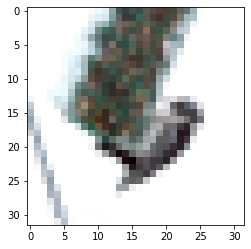

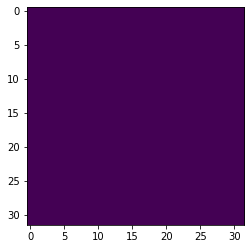

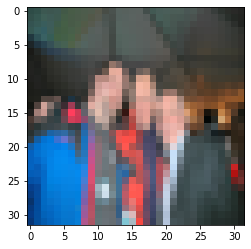

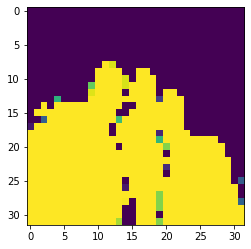

In [155]:
for x,y in ds.map(read_tfrecord).skip(555).take(2):
    plt.figure()
    plt.imshow(x.numpy())
    plt.show()
    
    plt.figure()
    plt.imshow(y.numpy())
    plt.show()

In [ ]:

example = tf.io.parse_single_example(ds, feature_description)

In [122]:
len(os.listdir('/home/aholdobin/faces/images/')) 

34426

In [11]:
train_test_split(['1','2','3','4','5','6','7'], test_size=.3, random_state=0)

[['4', '1', '6', '5'], ['7', '3', '2']]

In [4]:
ds_files = os.listdir('/home/aholdobin/tfrecords')
print(ds_files)

['cocoportrait_128x128_train_1.tfrecord', 'cocoportrait_128x128_val_7.tfrecord', 'cocoportrait_128x128_train_3.tfrecord', 'cocoportrait_128x128_train_5.tfrecord', 'cocoportrait_128x128_val_9.tfrecord', 'cocoportrait_128x128_train_14.tfrecord', 'pascalvoc_128x128_train_0.tfrecord', 'cocoportrait_128x128_train_15.tfrecord', 'cocoportrait_128x128_train_2.tfrecord', 'pascalvoc_128x128_train_1.tfrecord', 'cocoportrait_128x128_train_18.tfrecord', 'cocoportrait_128x128_train_8.tfrecord', 'cocoportrait_128x128_val_0.tfrecord', 'cocoportrait_128x128_train_23.tfrecord', 'cocoportrait_128x128_train_17.tfrecord', 'cocoportrait_128x128_train_11.tfrecord', 'cocoportrait_128x128_train_20.tfrecord', 'cocoportrait_128x128_train_22.tfrecord', 'cocoportrait_128x128_train_21.tfrecord', 'cocoportrait_128x128_train_0.tfrecord', 'cocoportrait_128x128_train_7.tfrecord', 'cocoportrait_128x128_train_13.tfrecord', 'cocoportrait_128x128_train_12.tfrecord', 'cocoportrait_128x128_val_2.tfrecord', 'pascalvoc_128x128

In [ ]:
val_filter = lambda x: x.find('val') >= 0
train_filter = lambda x: x.find('train') >= 0

In [ ]:
ds_train = a

In [19]:
ds = tf.data.TFRecordDataset(ds_files)

In [ ]:
def read_tfrecord(serialized_example):
    feature_description = {
        'x': tf.io.FixedLenFeature((), tf.string),
        'y': tf.io.FixedLenFeature((), tf.string),
    }
    example = tf.io.parse_single_example(
        serialized_example, feature_description)

    x = tf.io.parse_tensor(example['x'], out_type=tf.float32)
    y = tf.io.parse_tensor(example['y'], out_type=tf.float32)

    return x, y

In [21]:
ds = ds.map(read_tfrecord)

### Augmentations

In [9]:
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

In [4]:
augmentations = dict(
        rotation_range=15.,# RandomRotation tf.keras.layers.experimental.preprocessing.RandomRotation
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    )

In [94]:
augmentation_list = [{key:value} for key, value in augmentations.items()]
augmentation_list

[{'rotation_range': 15.0},
 {'width_shift_range': 0.05},
 {'height_shift_range': 0.05},
 {'shear_range': 50},
 {'zoom_range': 0.2},
 {'horizontal_flip': True},
 {'vertical_flip': False},
 {'fill_mode': 'constant'}]

In [102]:
generators = {list(d.keys())[0]: ImageDataGenerator(**d) for d in augmentation_list}

In [103]:
generators

{'rotation_range': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a9867a90>,
 'width_shift_range': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a98675d0>,
 'height_shift_range': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a9867b10>,
 'shear_range': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a98677d0>,
 'zoom_range': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a986b210>,
 'horizontal_flip': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a986b790>,
 'vertical_flip': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a986b550>,
 'fill_mode': <tensorflow.python.keras.preprocessing.image.ImageDataGenerator at 0x7f63a986be90>}

In [137]:
IMAGE = '/home/aholdobin/faces/images/1803151818-00000003.jpg'
IMAGE_NP = np.expand_dims(Image.open(IMAGE), axis=0)/255
# def show_generated_examples(generator):
#     gennerator.fit([IMAGE_NP])
#     plt.figure(figsize=[15, 5])
#     for i in range(3):
#         plt.subplot(131+i)
#         plt.imshow(generator)

In [138]:
IMAGE_NP.shape

(1, 800, 600, 3)

In [139]:
gen1 = ImageDataGenerator(**augmentations)
gen1.fit(IMAGE_NP)


In [144]:
random_transform = gen1.get_random_transform(IMAGE_NP.shape)
random_transform

{'theta': 3.5695788131642168,
 'tx': -0.025755224116116193,
 'ty': 11.294670648399007,
 'shear': -9.909883048534155,
 'zx': 1.1702519768870643,
 'zy': 1.0163110300108198,
 'flip_horizontal': 1,
 'flip_vertical': 0,
 'channel_shift_intensity': None,
 'brightness': None}

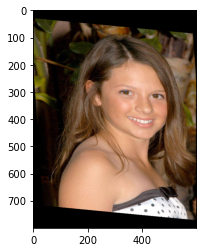

In [145]:
applied_transform = gen1.apply_transform(IMAGE_NP[0], random_transform)

plt.imshow(applied_transform)

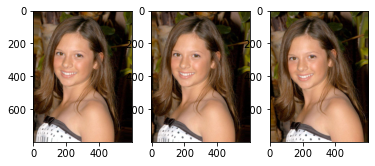

In [143]:
plt.figure()
for i in range(3):
    im = next(generators['rotation_range'].flow(IMAGE_NP))
    plt.subplot(131+i)
    plt.imshow(im[0])

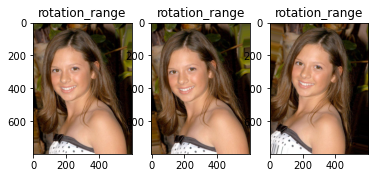

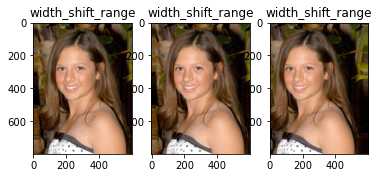

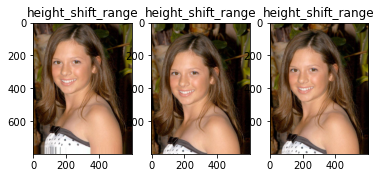

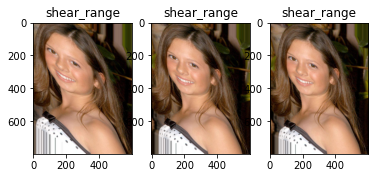

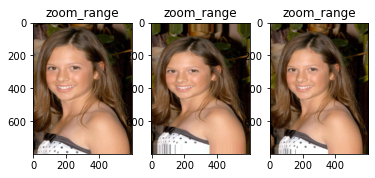

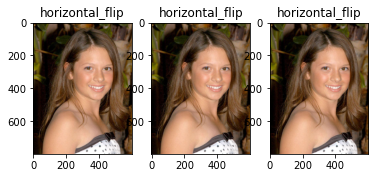

In [149]:
for gentype in generators.keys():
    if gentype in ('vertical_flip', 'fill_mode'): continue
    plt.figure()
    for i in range(3):
        im = next(generators[gentype].flow(IMAGE_NP))
        ax = plt.subplot(131+i)
        ax.set_title(gentype)
        plt.imshow(im[0])

### Read and augment data from TFRecords

In [2]:
augmentations = dict(
        rotation_range=15.,# RandomRotation tf.keras.layers.experimental.preprocessing.RandomRotation
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    )

AUTOTUNE = tf.data.experimental.AUTOTUNE

PASCAL_VOC_PERSON_CLASS_ID = 15
FEATURE_DESCRIPTION = {
    'x': tf.io.FixedLenFeature((), tf.string),
    'y': tf.io.FixedLenFeature((), tf.string),
}

def read_tfrecord(serialized_example):
    example = tf.io.parse_single_example(
        serialized_example, FEATURE_DESCRIPTION)

    x = tf.io.parse_tensor(example['x'], out_type=tf.float32)
    y = tf.io.parse_tensor(example['y'], out_type=tf.float32)

    return x, y

# def augment_with_generator(record, generator):
#     x, y = record
#     rt = generator.get_random_transform()
#     x_ = generator.apply_transform(x, rt)
#     # IMPORTANT: Changing parameters of ImageDataGenerator might require filter out transforms 
#     # which changes values of intensities such as brightness, contrast before applying to y
#     y_ = generator.apply_transform(y, rt)
#     return x_, y_

def prepare_dataset(augmentations,
                    ds_home='/home/aholdobin/tfrecords/',
                    shape=(32, 32),
                    batch_size=32,
                    verbose=False):

    def set_val_shape(x, y):
        x.set_shape((shape[0], shape[1], 3))
        y.set_shape((shape[0], shape[1], 1))
        return x, y
    
    def read_prepare_tfrecordsdataset(ds,
                                      batch_size=None,
                                      augment=None):
        ds = (ds.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
              .cache())
        if batch_size is None:
            raise ValueError()
        if augment:
            ds = (ds.shuffle(1024, seed=0, reshuffle_each_iteration=True)
                  .repeat()
                  .map(augment, num_parallel_calls=AUTOTUNE)
                  .batch(batch_size, drop_remainder=False)
                  .prefetch(AUTOTUNE))
        else:
            ds = (ds.map(set_val_shape, num_parallel_calls=AUTOTUNE)
                  .batch(batch_size, drop_remainder=False)
                  .prefetch(AUTOTUNE))
        return ds
    
    generator = ImageDataGenerator(**augmentations)
    
    def augment(x, y):
        rt = generator.get_random_transform((shape[0], shape[1], 3))
        x_ = generator.apply_transform(x, rt)
        # IMPORTANT: Changing parameters of ImageDataGenerator might require filter out transforms 
        # which changes values of intensities such as brightness, contrast before applying to y
        y_ = generator.apply_transform(y, rt)
        return x_, y_
    
    def augment_tf(x, y):
        x, y = tf.numpy_function(augment, [x, y], (tf.float32, tf.float32))
        x.set_shape((shape[0], shape[1], 3))
        y.set_shape((shape[0], shape[1], 1))
        return x, y
    
    records = os.listdir(ds_home)
    
    shape_str = "{}x{}".format(shape[0], shape[1])
    val_recs = [ds_home + rec for rec in records if rec.find('_val_') > 0 
                    and rec.find(shape_str) >= 0]
    train_recs = [ds_home + rec for rec in records if rec.find('_train_') > 0 
                    and rec.find(shape_str) >= 0]
    
    train_ds = read_prepare_tfrecordsdataset(
        tf.data.TFRecordDataset(train_recs, num_parallel_reads=AUTOTUNE),
        batch_size=batch_size,
        augment=augment_tf
    )
    val_ds = read_prepare_tfrecordsdataset(tf.data.TFRecordDataset(
        train_recs, num_parallel_reads=AUTOTUNE), batch_size=batch_size)
    return train_ds, val_ds


In [3]:
train_ds1, val_ds1 = prepare_dataset(augmentations=augmentations,
                    shape=(128, 128),
                    batch_size=128)

In [6]:
train_ds1, val_ds1

(<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>)

In [7]:
train_x, train_y

(<MapDataset shapes: (128, 128, 128, 3), types: tf.float32>,
 <MapDataset shapes: (128, 128, 128, 1), types: tf.float32>)

In [34]:
for rec in train_ds1.take(2):
    print(rec)

(<tf.Tensor: shape=(128, 128, 128, 3), dtype=float32, numpy=
array([[[[0.6       , 0.6313726 , 0.6431373 ],
         [0.60784316, 0.6392157 , 0.6509804 ],
         [0.62352943, 0.64705884, 0.6627451 ],
         ...,
         [0.45882353, 0.49019608, 0.5137255 ],
         [0.45490196, 0.4862745 , 0.50980395],
         [0.45490196, 0.49019608, 0.5137255 ]],

        [[0.59607846, 0.6313726 , 0.6392157 ],
         [0.59607846, 0.627451  , 0.6392157 ],
         [0.6039216 , 0.63529414, 0.64705884],
         ...,
         [0.45882353, 0.49411765, 0.5176471 ],
         [0.45490196, 0.49019608, 0.5137255 ],
         [0.45490196, 0.49019608, 0.5176471 ]],

        [[0.5882353 , 0.62352943, 0.63529414],
         [0.5921569 , 0.62352943, 0.63529414],
         [0.59607846, 0.627451  , 0.6392157 ],
         ...,
         [0.4627451 , 0.49019608, 0.5176471 ],
         [0.45490196, 0.49019608, 0.5176471 ],
         [0.45490196, 0.49019608, 0.5176471 ]],

        ...,

        [[0.5647059 , 0.5372549

In [151]:
!ls -la /home/aholdobin/tfrecords/

total 9424820
drwxrwxr-x  2 aholdobin aholdobin      4096 Sep 23 11:19 .
drwxr-xr-x 18 aholdobin aholdobin      4096 Sep 23 11:06 ..
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:06 cocoportrait_128x128_train_0.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:06 cocoportrait_128x128_train_1.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:10 cocoportrait_128x128_train_10.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:10 cocoportrait_128x128_train_11.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:11 cocoportrait_128x128_train_12.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:11 cocoportrait_128x128_train_13.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:12 cocoportrait_128x128_train_14.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:12 cocoportrait_128x128_train_15.tfrecord
-rw-rw-r--  1 aholdobin aholdobin 266700114 Sep 23 11:12 cocoportrait_128x128_train_16.tfrecord
-rw-r

In [174]:
ds_tmp

<CacheDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [180]:
t1

<TakeDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

### Training using tfrecords data

In [4]:
import gc
class GcCollectCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epochs, logs=None):
        gc.collect()

gccb = GcCollectCallback()

In [ ]:
model_filename = 'segm_ds.h5'
checkpoint_path = "training_18/weights_updated_ds.{epoch:03d}-{val_loss:.3f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

model = custom_unet(
    (128, 128, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

history = model.fit(
    train_ds1,
    steps_per_epoch=140,
    epochs=5,
    # batch_size=128,
    validation_data=val_ds1,
    callbacks=[callback_checkpoint, gccb]
)

Train for 140 steps
Epoch 1/5
139/140 [============================>.] - ETA: 0s - loss: 0.4258 - iou: 0.5647 - iou_thresholded: 0.6674
Epoch 00001: val_loss improved from inf to 0.55952, saving model to training_18/weights_updated_ds.001-0.560.hdf5
140/140 [==============================] - 56s 397ms/step - loss: 0.4246 - iou: 0.5659 - iou_thresholded: 0.6685 - val_loss: 0.5595 - val_iou: 0.6817 - val_iou_thresholded: 0.7043
Epoch 2/5
139/140 [============================>.] - ETA: 0s - loss: 0.2630 - iou: 0.7129 - iou_thresholded: 0.7951
Epoch 00002: val_loss improved from 0.55952 to 0.24656, saving model to training_18/weights_updated_ds.002-0.247.hdf5
140/140 [==============================] - 134s 958ms/step - loss: 0.2629 - iou: 0.7131 - iou_thresholded: 0.7952 - val_loss: 0.2466 - val_iou: 0.7852 - val_iou_thresholded: 0.8220
Epoch 3/5
139/140 [============================>.] - ETA: 0s - loss: 0.2005 - iou: 0.7863 - iou_thresholded: 0.8532

In [5]:
import subprocess

In [20]:
cmd = 'python AUnetBackgroundRemoval.py -r /home/aholdobin/tfrecords/ -v 0 -sd {side} -e {epochs} -b {batch_size} -f {filters} -l'
models_parameters128 = [
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side64_filters8',
#         'side': 64,
#         'batch_size': 512,
#         'filters': 8,
#         'epochs': 500
#     },
        {'name': 'side128_filters8',
        'side': 128,
        'batch_size': 128,
        'filters': 8,
        'epochs': 500
    },
#         {'name': 'side32_filters16',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 16,
#         'epochs': 500
#     },
#         {'name': 'side64_filters16',
#         'side': 64,
#         'batch_size': 512,
#         'filters': 16,
#         'epochs': 500
#     },
        {'name': 'side128_filters16',
        'side': 128,
        'batch_size': 128,
        'filters': 16,
        'epochs': 500
    },
#         {'name': 'side32_filters12',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 12,
#         'epochs': 500
#     },
#         {'name': 'side64_filters12' ,
#         'side': 64,
#         'batch_size': 512,
#         'filters': 12,
#         'epochs': 500
#     },
        {'name': 'side128_filters12' ,
        'side': 128,
        'batch_size': 128,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,htop
#         'epochs': 500
#     },
]

for value in models_parameters128:
    with open(value['name'] + '.log', 'w') as f:
        #if value['filters'] == 12:
        print(value)
        proc = subprocess.call(cmd.format(**value).split(), stdout=f, stderr=subprocess.STDOUT)
        print(proc)

{'name': 'side128_filters12', 'side': 128, 'batch_size': 128, 'filters': 12, 'epochs': 500}
0


In [ ]:
!cat side128_filters16.log

In [21]:
cmd_tflite = 'python AUnetBackgroundRemoval.py -v 1 -sd {side} -f {filters} -l'.format(**{
        'name': 'side128_filters12' ,
        'side': 128,
        'batch_size': 128,
        'filters': 12,
        'epochs': 500
    })

In [22]:
cmd_tflite

'python AUnetBackgroundRemoval.py -v 1 -sd 128 -f 12 -l'

In [23]:
subprocess.call(cmd_tflite.split())

0

In [11]:
import os; print(os.listdir())

['tfjs', 'README.md', 'side32_filters12.log', 'video_v9.py', 'eda-ish.ipynb', 'side64_filters8.log', 'best', 'side128_filters16.log', 'segm_model_v5_0065.h5', 'side64_filters16.log', 'segm_model_v9.h5', 'golden-gate.jpg', 'side32_filters16.log', 'converter.py', 'AUnetBackgroundRemoval.py', 'side32_filters8.log', 'training_grid', 'semsegm_of8000.tflite', 'side128_filters8.log', 'side128_filters12.log2', 'training_17', 'data_dict.p', '.ipynb_checkpoints', 'segm_model_v4_32_mega.h5', 'video.py', 'keras_to_tensorflow.py', 'convert.sh', 'w.json', 'experiment_results', 'training_18', 'demo.png', 'side64_filters12.log', 'side128_filters16.log2', 'data_preparation.py', 'side128_filters12.log', 'faces', '__pycache__', 'unet.py', 'tflite', 'requirements.txt', 'side128_filters8.log2']


### REPORT History overview

#### tests and other checks

In [2]:
import json
path = '/home/aholdobin/ar-video-conf-mobile-demo/python/training_grid/fil_{fil}_shape_{sd}x{sd}/history_fil_{fil}_shape_{sd}x{sd}.json'

In [14]:
hist_8_64_path = path.format(fil=8, sd=64)
with open(hist_8_64_path) as f:
    hist_8_64 = json.load(f)

In [15]:
hist_8_64.keys()

dict_keys(['loss', 'iou', 'iou_thresholded', 'val_loss', 'val_iou', 'val_iou_thresholded'])

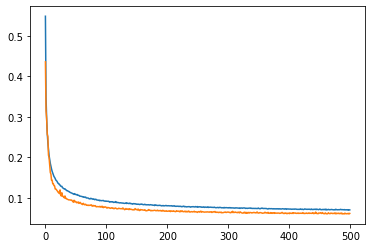

In [17]:
plt.plot(hist_8_64['loss'])
plt.plot(hist_8_64['val_loss'])

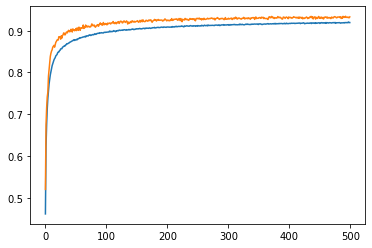

In [18]:
plt.plot(hist_8_64['iou'])
plt.plot(hist_8_64['val_iou'])

#### Setting up required variables

In [4]:
import json
path = '/home/aholdobin/ar-video-conf-mobile-demo/python/training_grid/fil_{fil}_shape_{sd}x{sd}/history_fil_{fil}_shape_{sd}x{sd}.json'


histories = []

shapes = [32, 64, 128]
fils = [8, 12, 16]
for shn in range(len(shapes)):
    histories.append([])
    for fn in range(len(fils)):
        with open(path.format(sd=shapes[shn],fil=fils[fn])) as f:
            histories[shn].append(json.load(f))

#### Report 1 : Metrics comparison - training vs validation 

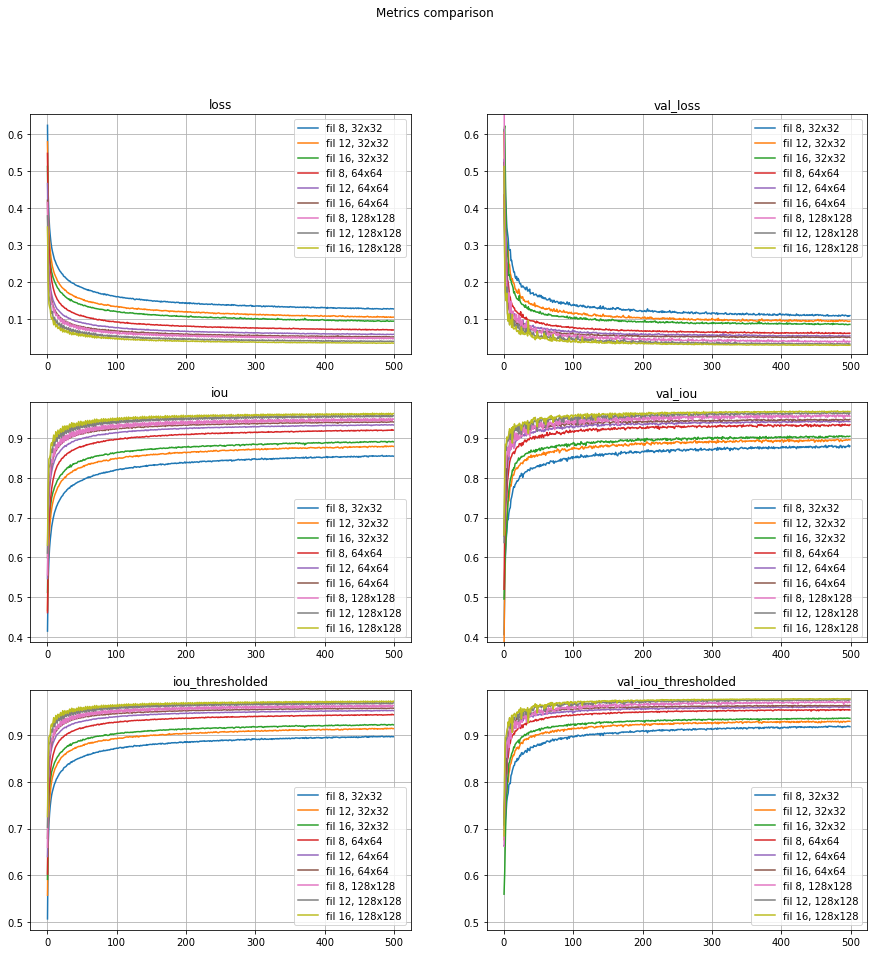

In [5]:
metrics = ['loss', 'iou', 'iou_thresholded']
leg_fmt = 'fil {fil}, {sd}x{sd}'
fig = plt.figure(figsize=(15,15))#, ax 
fig.suptitle('Metrics comparison')
legends =[]
for metn in range(len(metrics)):
    ax1 = plt.subplot(3,2,1+metn*2)
    ax1.set_title(metrics[metn])
    l=[]
    for shn in range(len(shapes)):
        for fn in range(len(fils)):
            l.append(plt.plot(histories[shn][fn][metrics[metn]])[0])#[shn*len(shapes)+fn] = 
            if metn == 0:
                legends.append(leg_fmt.format(fil=fils[fn], sd=shapes[shn]))
    ax1.legend(l, legends, loc='upper right' if metn==0 else 'lower right')
    ax1.grid(True)
    
    l=[]
    ax2 = plt.subplot(3,2,2+metn*2)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_title('val_' + metrics[metn])
    for shn in range(len(shapes)):
        for fn in range(len(fils)):
            l.append(plt.plot(histories[shn][fn]['val_'+metrics[metn]])[0])#[shn*len(shapes)+fn] = 
            
    ax2.legend(l, legends, loc='upper right' if metn==0 else 'lower right')
    ax2.grid(True)
        

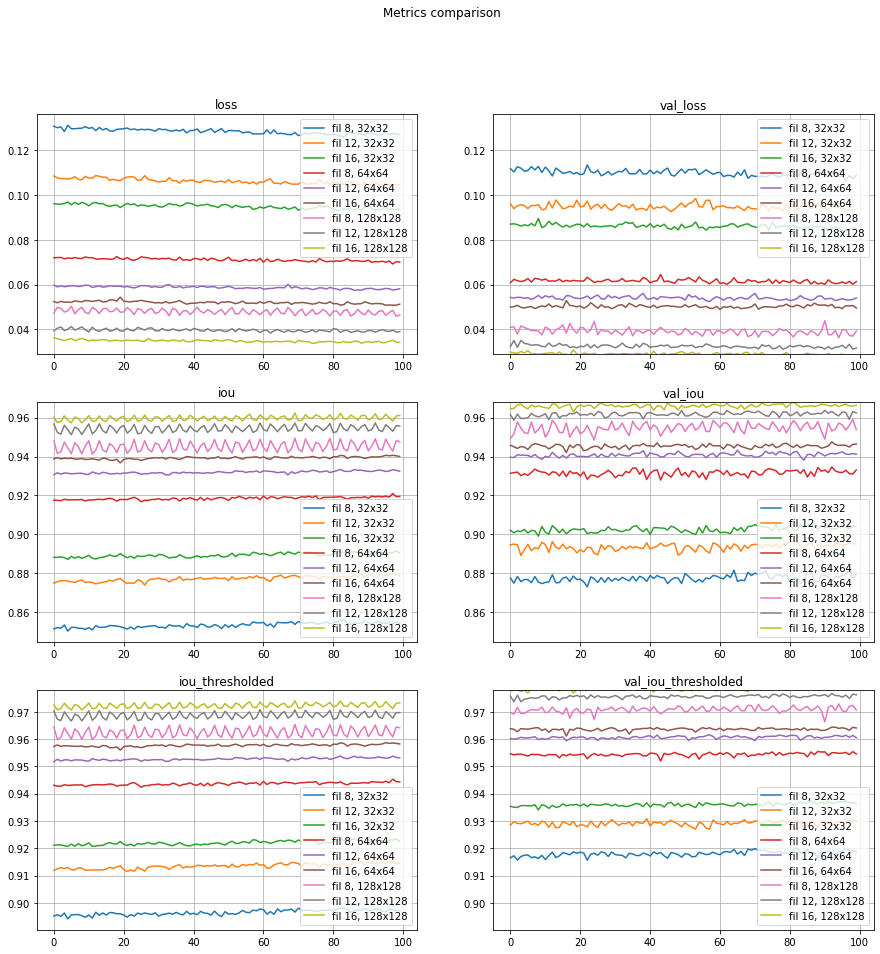

In [7]:
def plot_metrics_comperison(first=0, last=500):
    metrics = ['loss', 'iou', 'iou_thresholded']
    leg_fmt = 'fil {fil}, {sd}x{sd}'
    fig = plt.figure(figsize=(15,15))#, ax 
    fig.suptitle('Metrics comparison')
    legends =[]
    for metn in range(len(metrics)):
        ax1 = plt.subplot(3,2,1+metn*2)
        ax1.set_title(metrics[metn])
        l=[]
        for shn in range(len(shapes)):
            for fn in range(len(fils)):
                l.append(plt.plot(histories[shn][fn][metrics[metn]][first:last])[0])#[shn*len(shapes)+fn] = 
                if metn == 0:
                    legends.append(leg_fmt.format(fil=fils[fn], sd=shapes[shn]))
        ax1.legend(l, legends, loc='upper right' if metn==0 else 'lower right')
        ax1.grid(True)

        l=[]
        ax2 = plt.subplot(3,2,2+metn*2)
        ax2.set_ylim(ax1.get_ylim())
        ax2.set_title('val_' + metrics[metn])
        for shn in range(len(shapes)):
            for fn in range(len(fils)):
                l.append(plt.plot(histories[shn][fn]['val_'+metrics[metn]][first:last])[0])#[shn*len(shapes)+fn] = 

        ax2.legend(l, legends, loc='upper right' if metn==0 else 'lower right')
        ax2.grid(True)
plot_metrics_comperison(first=400, last=500)

#### Report 2 : Models comparison - by number of filters and input size

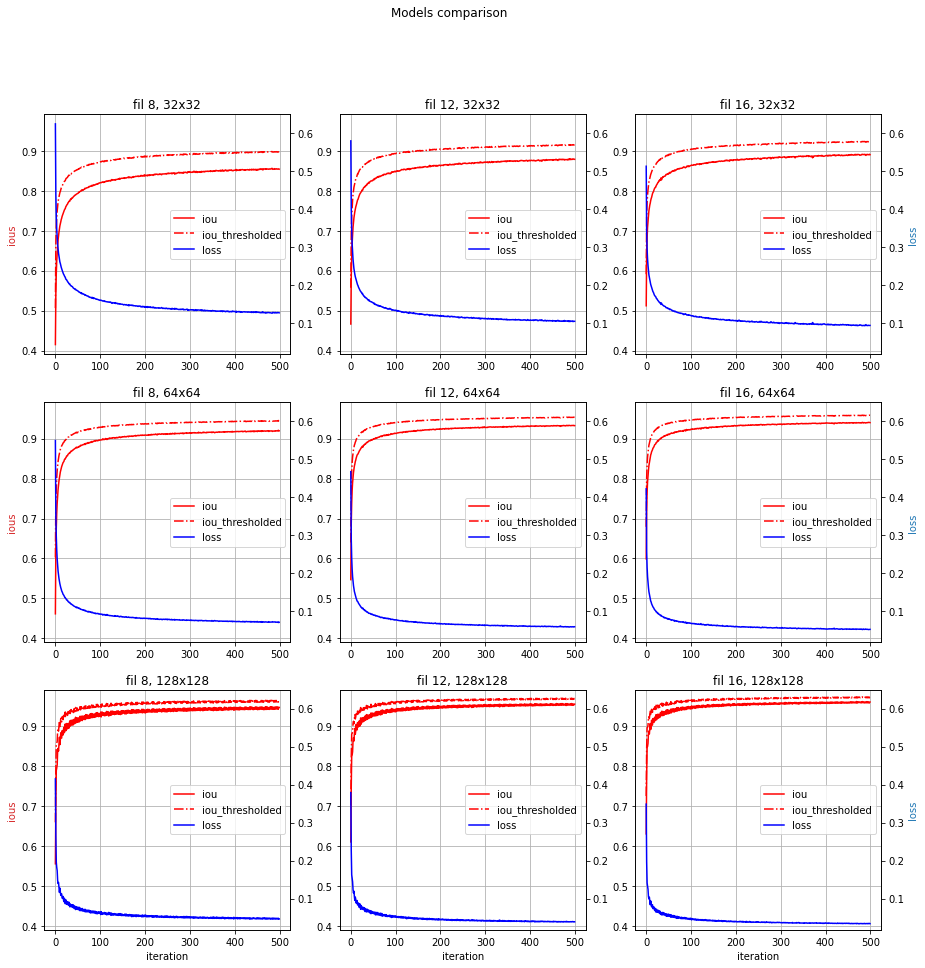

In [21]:
metrics = ['iou', 'iou_thresholded', 'loss', ]
leg_fmt = 'fil {fil}, {sd}x{sd}'
fig = plt.figure(figsize=(15,15))
fig.suptitle('Models comparison')
legends =[]
axes1 = []
axes2 = []
for shn in range(len(shapes)):
    for fn in range(len(fils)):
        lines=[]
        ax1 = plt.subplot(3,3,shn*3+fn+1)
        if shn==2: ax1.set_xlabel('iteration')
        if fn==0: ax1.set_ylabel('ious', color='tab:red')
        ax1.set_title(leg_fmt.format(fil=fils[fn], sd=shapes[shn]))
        lines.append(plt.plot(histories[shn][fn][metrics[0]], color='r', ls='-')[0])
        lines.append(plt.plot(histories[shn][fn][metrics[1]],color='r', ls='-.')[0])
        if metn == 0:
            legends.append(leg_fmt.format(fil=fils[fn], sd=shapes[shn]))
        ax2 = ax1.twinx()

        if fn==2: ax2.set_ylabel('loss', color='tab:blue')
        lines.append(plt.plot(histories[shn][fn][metrics[2]],color='b')[0])
        axes1.append(ax1)
        axes2.append(ax2)            
        ax1.legend(lines, metrics, loc='center right')
        ax1.grid(True)

lims1 = ax1.get_ylim()
lims2 = ax2.get_ylim()
for i in range(len(axes1)):
    limst = axes1[i].get_ylim()
    lims1 = (min(lims1[0],limst[0]),max(lims1[1],limst[1]))
    limst = axes2[i].get_ylim()
    lims2 = (min(lims2[0],limst[0]),max(lims2[1],limst[1]))
for i in range(len(axes1)):
    axes1[i].set_ylim(lims1)
    axes2[i].set_ylim(lims2)


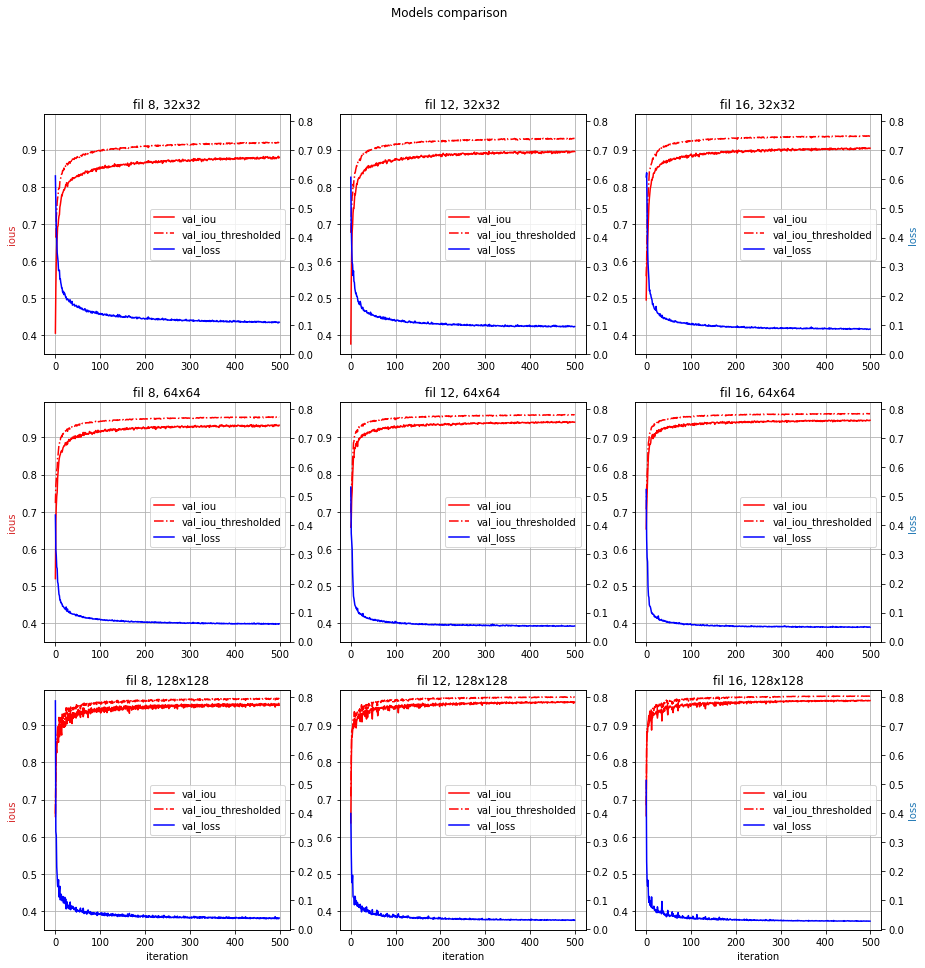

In [22]:
metrics = ['val_iou', 'val_iou_thresholded', 'val_loss', ]
leg_fmt = 'fil {fil}, {sd}x{sd}'
fig = plt.figure(figsize=(15,15))
fig.suptitle('Models comparison')
legends =[]
axes1 = []
axes2 = []
for shn in range(len(shapes)):
    for fn in range(len(fils)):
        lines=[]
        ax1 = plt.subplot(3,3,shn*3+fn+1)
        if shn==2: ax1.set_xlabel('iteration')
        if fn==0: ax1.set_ylabel('ious', color='tab:red')
        ax1.set_title(leg_fmt.format(fil=fils[fn], sd=shapes[shn]))
        lines.append(plt.plot(histories[shn][fn][metrics[0]], color='r', ls='-')[0])
        lines.append(plt.plot(histories[shn][fn][metrics[1]],color='r', ls='-.')[0])
        if metn == 0:
            legends.append(leg_fmt.format(fil=fils[fn], sd=shapes[shn]))
        ax2 = ax1.twinx()

        if fn==2: ax2.set_ylabel('loss', color='tab:blue')
        lines.append(plt.plot(histories[shn][fn][metrics[2]],color='b')[0])
        axes1.append(ax1)
        axes2.append(ax2)            
        ax1.legend(lines, metrics, loc='center right')
        ax1.grid(True)

lims1 = ax1.get_ylim()
lims2 = ax2.get_ylim()
for i in range(len(axes1)):
    limst = axes1[i].get_ylim()
    lims1 = (min(lims1[0],limst[0]),max(lims1[1],limst[1]))
    limst = axes2[i].get_ylim()
    lims2 = (min(lims2[0],limst[0]),max(lims2[1],limst[1]))
for i in range(len(axes1)):
    axes1[i].set_ylim(lims1)
    axes2[i].set_ylim(lims2)


#### Report 3: Table of best metrics scores across trained models

In [51]:
from matplotlib import __version__ as matplotlib__version__;matplotlib__version__

'3.3.1'

In [6]:
def best_metrics(hist):
    val_loss = np.argmin(hist['val_loss'])
    loss = np.argmin(hist['loss'])
    val_iou = np.argmax(hist['val_iou'])
    iou = np.argmax(hist['iou'])
    val_iou_thresholded = np.argmax(hist['val_iou_thresholded'])
    iou_thresholded = np.argmax(hist['iou_thresholded'])
    return (('val_loss', val_loss, hist['val_loss'][val_loss]),
            ('loss', loss, hist['loss'][loss]),
            ('val_iou', val_iou, hist['val_iou'][val_iou]),
            ('iou', iou, hist['iou'][iou]),
            ('val_iou_thresholded', val_iou_thresholded, hist['val_iou_thresholded'][val_iou_thresholded]),
            ('iou_thresholded', iou_thresholded, hist['iou_thresholded'][iou_thresholded]))
            

In [7]:
res = dict()
for shn in range(len(shapes)):
    for fn in range(len(fils)):
        key = leg_fmt.format(fil=fils[fn], sd=shapes[shn])
        value = best_metrics(histories[shn][fn])
        res[key] = value
        print('#'*40)
        print(key)
        print(value)


########################################
fil 8, 32x32
(('val_loss', 496, 0.10652779296222668), ('loss', 483, 0.12589035138231647), ('val_iou', 497, 0.8821876645088196), ('iou', 483, 0.8562195897102356), ('val_iou_thresholded', 482, 0.9201502203941345), ('iou_thresholded', 483, 0.8982118368148804))
########################################
fil 12, 32x32
(('val_loss', 446, 0.09257805111277098), ('loss', 486, 0.10407710568141991), ('val_iou', 412, 0.8962618112564087), ('iou', 488, 0.8798313736915588), ('val_iou_thresholded', 439, 0.9308480620384216), ('iou_thresholded', 496, 0.9153842329978943))
########################################
fil 16, 32x32
(('val_loss', 496, 0.08419120055739293), ('loss', 488, 0.09320263736098316), ('val_iou', 487, 0.9054186344146729), ('iou', 498, 0.8913922905921936), ('val_iou_thresholded', 496, 0.937395453453064), ('iou_thresholded', 486, 0.9234387874603271))
########################################
fil 8, 64x64
(('val_loss', 490, 0.060119678776962907), ('loss

In [8]:
res_table = pd.DataFrame(res).transpose();
res_table.columns = 'val_loss', 'loss', 'val_iou', 'iou', 'val_iou_thresholded', 'iou_thresholded'
for column in res_table.columns:
    res_table[column + '_epoch'] = res_table[column].map(lambda x: x[1])
    #res_table[column] = res_table[column].map(lambda x: x[2])
    if 'loss' in column:
        res_table[column] = res_table[column].map(lambda x: x[2])
    else:
        res_table[column] = res_table[column].map(lambda x: round(x[2]*100, 2))

In [ ]:
res_table.iloc[:, :6]

### Models evaluation

#### Evaluation on original images

In [1]:
import os, gc
from keras_unet.metrics_np import iou_np, iou_thresholded_np
import os
import cv2
import numpy as np
#import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

PASCAL_VOC_PERSON_CLASS_ID = 15

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
def get_coco_validation(dataset_home='/home/aholdobin/faces/',):

    if dataset_home and os.path.exists(dataset_home):
        files = list(
            map(lambda x: x[:-4] if x.endswith('jpg') else None, os.listdir(dataset_home+'images/')))
        if len(files) == 0:
            raise ValueError("`files` must contain at least 1 element")

        f_train, f_val = train_test_split(files, test_size=0.3, random_state=0)
        
        ds_val = []
        for file in f_val:
            if file and os.path.exists(dataset_home + f'images/{file}.jpg'):
                x = np.array(Image.open(
                    dataset_home + f'images/{file}.jpg'), dtype='float32')/255.
                y = np.array(Image.open(
                    dataset_home + f'masks/{file}.png'), dtype='float32')[:, :, -1]/255.
                
                yield (x, y.reshape([y.shape[0], y.shape[1], 1]))


def get_pascal_validation(dataset_home='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/',):

    if dataset_home and os.path.exists(dataset_home):

        segmentation_meta_path = dataset_home + 'ImageSets/Segmentation/trainval.txt'
        segmentation_folder = dataset_home + 'SegmentationClass/'
        images_folder = dataset_home + 'JPEGImages/'

        with open(segmentation_meta_path) as f:
            files = f.read().split('\n')
        
        if len(files) == 0:
            raise ValueError("`files` must contain at least 1 element")

        _, f_val = train_test_split(files, test_size=0.3, random_state=0)
        
        ds_val = []
        for file in f_val:
            if file and os.path.exists(images_folder + f'{file}.jpg'):
                y = (np.array(Image.open(
                    segmentation_folder + file + '.png')) == PASCAL_VOC_PERSON_CLASS_ID).astype('float32')
                tmean = y.mean()
                if 0 < tmean <= .15:
                    continue
                x = np.array(Image.open(images_folder + file +
                                        '.jpg'), dtype='float32')/255.
                yield (x, y.reshape([y.shape[0], y.shape[1], 1]))
                gc.collect()

In [30]:
get_pascal_validation()

<generator object get_pascal_validation at 0x7f18e2b66150>

In [19]:
gc.collect()

40

In [32]:
# Modified code from (TensorFlow)[https://www.tensorflow.org/model_optimization/guide/quantization/training_example#see_persistence_of_accuracy_from_tf_to_tflite]

def evaluate_model(interpreter, input_size, dataset_generator):
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    prediction_digits = []

    for x, y in dataset_generator:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        if x.shape[0] != input_size[0] or x.shape[1] != input_size[1]:
            scaled = True
            img = np.expand_dims(cv2.resize(x, dsize=input_size), axis=0).astype(np.float32)
        else:
            img = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, img)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        
        if scaled:
            output = cv2.resize(output, dzise=tuple(x[i].shape[:2]))
        
        dist = iou_np(y, output), iou_thresholded_np(y, output)
        
        scores.append(dist)

        # print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    mean_scores = np.mean(scores, axis=0)
    return mean_scores, scores

In [24]:
model_path = 'semsegm_of8000.tflite'

model = tf.lite.Interpreter(model_path=model_path)
model.allocate_tensors()

In [33]:
m, s = evaluate_model(model, (32, 32), get_validation_dataset())

TypeError: 'NoneType' object is not iterable